# Train the Tokenizer

In [5]:
from tokenizers import BertWordPieceTokenizer, ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from pathlib import Path
import os

# paths = [str(x) for x in Path(".").glob("text_split/*.txt")]
path = os.path.realpath("../data/nim_fen.txt")

tokenizer_folder = os.path.realpath("./bert-nim")

MAX_LEN = 128

vocab_size = 16384

In [7]:




# Initialize a tokenizer
tokenizer = BertWordPieceTokenizer(lowercase=False, clean_text=True)
print(tokenizer.add_special_tokens(["[MOVESEP]"]))

print(tokenizer.get_vocab())

# Customize training
tokenizer.train(files=path, vocab_size=vocab_size, min_frequency=1,
                show_progress=True,
                special_tokens= ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[MOVESEP]'])

print(tokenizer.get_vocab())
#Save the Tokenizer to disk
#tokenizer.save(tokenizer_folder + "/vocab.json")
#tokenizer.save_model(tokenizer_folder)

1
{'[MOVESEP]': 0}



{'##P': 37, 'a': 27, '6': 13, 'a1': 52, '5': 12, 'a0': 54, '[SEP]': 3, '3': 10, 'b6': 69, 'A': 17, 'a8': 78, 'S': 23, 'c7': 72, 'c8': 75, 'MOVE': 49, ']': 26, '[UNK]': 1, '7': 14, '##3': 31, 'MOVESEP': 50, 'a5': 68, '[CLS]': 2, 'b10': 82, 'b9': 79, 'a4': 65, 'b0': 55, '0': 7, '[MOVESEP]': 0, '9': 16, 'b7': 73, '##0': 42, 'c': 29, '##2': 44, 'b2': 58, '##6': 30, '[': 25, 'V': 24, '##4': 40, '1': 8, '8': 15, 'MO': 45, 'a6': 71, '##EP': 47, '4': 11, 'b3': 62, 'c9': 77, 'a2': 59, 'b5': 66, 'P': 22, '[PAD]': 0, 'b1': 53, '##E': 35, '##5': 43, 'M': 20, 'b': 28, 'c4': 63, 'a7': 74, 'c1': 51, 'b8': 76, '##O': 33, 'c10': 80, '##V': 34, 'a9': 81, 'c0': 56, 'c2': 57, 'b4': 64, '##8': 38, 'c5': 67, 'B': 18, 'c6': 70, '/': 6, 'E': 19, 'c3': 61, '2': 9, 'a10': 83, '[MASK]': 4, '##1': 39, '##7': 41, 'O': 21, '##VE': 46, '##S': 36, 'a3': 60, '##SEP': 48, '##9': 32}


In [8]:
tokenizer.save_model(tokenizer_folder)

['/Users/michaeldeleo/PycharmProjects/NLP-Chess/src/bert/bert-nim/vocab.txt']

In [10]:
import os


BertWordPieceTokenizer(os.path.join(tokenizer_folder, "vocab.txt"))
# Prepare the tokenizer
# tokenizer._tokenizer.post_processor = BertProcessing(
#     ("</s>", tokenizer.token_to_id("</s>")),
#     ("<s>", tokenizer.token_to_id("<s>")),
# )
tokenizer.enable_truncation(max_length=128)
# Test the tokenizer
tokenizer.encode("a1/b9/c9 [MOVESEP] a2")
# Show the tokens created
tokenizer.encode("a1/b9/c9 [MOVESEP] a2 [MASK]").tokens

['a1', '/', 'b9', '/', 'c9', '[MOVESEP]', 'a2', '[MASK]']

In [11]:
!pip list

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Package              Version
-------------------- ---------
aiohttp              3.8.1
aiosignal            1.2.0
anyio                3.5.0
appnope              0.1.2
argon2-cffi          21.3.0
argon2-cffi-bindings 21.2.0
asttokens            2.0.5
async-timeout        4.0.2
attrs                21.4.0
Babel                2.9.1
backcall             0.2.0
black                22.1.0
bleach               3.1.5
certifi              2020.6.20
cffi                 1.15.0
chardet              3.0.4
charset-normalizer   2.0.12
chess                1.8.0
click                8.0.3
colorama             0.4.3
cycler               0.11.0
Cython               0.29.28
datasets 

In [5]:
from transformers import BertConfig
from transformers import BertForMaskedLM

from transformers import BertTokenizer

# Set a configuration for our RoBERTa model
config = BertConfig(
    vocab_size=vocab_size,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)
# Initialize the model from a configuration without pretrained weights
model = BertForMaskedLM(config=config)
print('Num parameters: ',model.num_parameters())

# Create the tokenizer from a trained one
tokenizer = BertTokenizer.from_pretrained(tokenizer_folder + "/vocab.txt", max_len=MAX_LEN)

Num parameters:  56115712


/home/michael/Workspace/nlp-chess/env/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1648: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  FutureWarning,


# Build the Dataset

In [7]:
from datasets import load_dataset
from datasets import set_caching_enabled
raw_datasets = load_dataset('text', data_files=path,
                            split='train')

#cut size in half
raw_datasets = raw_datasets.shuffle(seed=42)

#raw_datasets = raw_datasets.select(range(10000))
raw_datasets = raw_datasets.train_test_split()


def tokenize_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, keep_in_memory=True, num_proc=20, remove_columns=["text"])

Using custom data configuration default-cc76579b29d52e13
Reusing dataset text (/home/michael/.cache/huggingface/datasets/text/default-cc76579b29d52e13/0.0.0/d86c40dad297bdddf277b406c6a59f0250b5318c400bf23d420a31aff88c84c4)
Loading cached shuffled indices for dataset at /home/michael/.cache/huggingface/datasets/text/default-cc76579b29d52e13/0.0.0/d86c40dad297bdddf277b406c6a59f0250b5318c400bf23d420a31aff88c84c4/cache-ea496f9ced065590.arrow


In [21]:
tokenized_datasets["train"][1]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'input_ids': [2,
  52,
  6,
  55,
  6,
  51,
  28,
  25,
  1,
  26,
  51,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [8]:
# tokenized_datasets = raw_datasets
#     with open("dataset-tokenized.obj", 'wb') as f:
#         pickle.dump(tokenized_datasets, f)

# block_size = tokenizer.model_max_length

block_size = 128

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    #result["labels"] = result["input_ids"].copy()
    return result
print(tokenized_datasets["train"][1])
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=20,
    keep_in_memory=True
)

print("grouping complete")

small_train_dataset = lm_datasets["train"].shuffle(seed=42).select(range(1000))
# small_train_dataset["labels"] = small_train_dataset["input_ids"]
small_eval_dataset = lm_datasets["test"].shuffle(seed=42).select(range(1000))
# small_eval_dataset["labels"] = small_eval_dataset["input_ids"]
full_train_dataset = lm_datasets["train"]
full_eval_dataset = lm_datasets["test"]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'input_ids': [2, 52, 6, 55, 6, 51, 28, 25, 1, 26, 51, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
len(tokenized_datasets["train"])

15065

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    per_device_train_batch_size=425,
    output_dir='./output-nim', 
    num_train_epochs=2000,
    evaluation_strategy="epoch")

from transformers import Trainer, DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.15,
)

trainer = Trainer(
    model=model, args=training_args, train_dataset=full_train_dataset, eval_dataset=full_eval_dataset, data_collator=data_collator
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 15065
  Num Epochs = 2000
  Instantaneous batch size per device = 425
  Total train batch size (w. parallel, distributed & accumulation) = 425
  Gradient Accumulation steps = 1
  Total optimization steps = 72000


Epoch,Training Loss,Validation Loss
1,No log,0.368579
2,No log,0.369066
3,No log,0.372252
4,No log,0.358123
5,No log,0.355157
6,No log,0.380127
7,No log,0.359101
8,No log,0.365833
9,No log,0.378416
10,No log,0.364706


***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5022
  Batch size = 8
Saving model checkpoint to ./output-nim/checkpoint-500
Configuration saved in ./output-nim

TrainOutput(global_step=72000, training_loss=0.3233491039276123, metrics={'train_runtime': 64525.6236, 'train_samples_per_second': 466.946, 'train_steps_per_second': 1.116, 'total_flos': 9.981897572352e+17, 'train_loss': 0.3233491039276123, 'epoch': 2000.0})

In [11]:
trainer.save_model("trained_model2")

Saving model checkpoint to trained_model2
Configuration saved in trained_model2/config.json
Model weights saved in trained_model2/pytorch_model.bin


In [1]:
from BertHarmon import BertHarmon
from stockfish import Stockfish
from tqdm import tqdm_notebook as tqdm
import os

REPO_DIR = os.path.realpath("../../")

STOCKFISH_BINARY_PATH = os.path.join(REPO_DIR,
                                     "stockfish_build",
                                     "stockfish",
                                     "src",
                                     "stockfish")

class EvaluateValidMoves:
    
    def __init__(self, model_checkpoint, tokenizer_checkpoint, num_games=100, max_moves=3):
        self.model = BertHarmon(model_checkpoint, tokenizer_checkpoint)
        
        self.num_games = num_games
        self.max_moves = max_moves
        
    def test(self):
        valid_moves_per_game = []
        for game_num in tqdm(range(self.num_games)):
            # Setup the game
            self.stockfish = Stockfish(path=STOCKFISH_BINARY_PATH,
                                       parameters={"Threads": 1,
                                                   "Minimum Thinking Time": 50,
                                                   "Use NNUE": True})

            self.stockfish.set_elo_rating(3900)
            self.stockfish.set_depth(1)
            
            # run the game
            num_valid_moves = 0
            moves = []
            for i in range(self.max_moves):
                
                # stockfish move
                
                move = self.stockfish.get_best_move()
                moves.append(move)
                
                self.stockfish.make_moves_from_current_position([move])
                
                # bert move
                
                move = self.model.make_move(self.stockfish.get_fen_position())[0]["token_str"].replace(" ", "")
                
                if self.stockfish.is_move_correct(move):
                    moves.append(move)
                    num_valid_moves += 1
                    self.stockfish.make_moves_from_current_position([move])
                else:
                    move = self.stockfish.get_best_move()
                    if move is None:
                        num_valid_moves += self.max_moves - i
                        break
                    moves.append(move)
                    self.stockfish.make_moves_from_current_position([move])
            #print(moves)       
            #with open(f"games/{game_num}.txt", "w") as f:
            #    f.write("\n".join(moves))
            valid_moves_per_game.append(num_valid_moves)
            
        return valid_moves_per_game
                
                
            


In [3]:
import numpy as np

benchmark = []
for i in range(1, 40):
    print(i)
    res = EvaluateValidMoves("trained_model2", "./bert-harmon/vocab.txt", max_moves=i).test()
    benchmark.append(np.average(res) / i)


#Evaluator = EvaluateValidMoves("trained_model2", "./bert-harmon/vocab.txt", max_moves=moves)
#num_valid_moves = Evaluator.test()



#print(np.average(num_valid_moves))
#print(np.average(num_valid_moves) / moves)

1


/home/michael/Workspace/nlp-chess/env/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

2


  0%|          | 0/100 [00:00<?, ?it/s]

3


  0%|          | 0/100 [00:00<?, ?it/s]

4


  0%|          | 0/100 [00:00<?, ?it/s]

5


  0%|          | 0/100 [00:00<?, ?it/s]

6


  0%|          | 0/100 [00:00<?, ?it/s]

7


  0%|          | 0/100 [00:00<?, ?it/s]

8


  0%|          | 0/100 [00:00<?, ?it/s]

9


  0%|          | 0/100 [00:00<?, ?it/s]

10


  0%|          | 0/100 [00:00<?, ?it/s]

11


  0%|          | 0/100 [00:00<?, ?it/s]

12


  0%|          | 0/100 [00:00<?, ?it/s]

13


  0%|          | 0/100 [00:00<?, ?it/s]

14


  0%|          | 0/100 [00:00<?, ?it/s]

15


  0%|          | 0/100 [00:00<?, ?it/s]

16


  0%|          | 0/100 [00:00<?, ?it/s]

17


  0%|          | 0/100 [00:00<?, ?it/s]

18


  0%|          | 0/100 [00:00<?, ?it/s]

19


  0%|          | 0/100 [00:00<?, ?it/s]

20


  0%|          | 0/100 [00:00<?, ?it/s]

21


  0%|          | 0/100 [00:00<?, ?it/s]

22


  0%|          | 0/100 [00:00<?, ?it/s]

23


  0%|          | 0/100 [00:00<?, ?it/s]

24


  0%|          | 0/100 [00:00<?, ?it/s]

25


  0%|          | 0/100 [00:00<?, ?it/s]

26


  0%|          | 0/100 [00:00<?, ?it/s]

27


  0%|          | 0/100 [00:00<?, ?it/s]

28


  0%|          | 0/100 [00:00<?, ?it/s]

29


  0%|          | 0/100 [00:00<?, ?it/s]

30


  0%|          | 0/100 [00:00<?, ?it/s]

31


  0%|          | 0/100 [00:00<?, ?it/s]

32


  0%|          | 0/100 [00:00<?, ?it/s]

33


  0%|          | 0/100 [00:00<?, ?it/s]

34


  0%|          | 0/100 [00:00<?, ?it/s]

35


  0%|          | 0/100 [00:00<?, ?it/s]

36


  0%|          | 0/100 [00:00<?, ?it/s]

37


  0%|          | 0/100 [00:00<?, ?it/s]

38


  0%|          | 0/100 [00:00<?, ?it/s]

39


  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
benchmark

[1.0,
 1.0,
 1.0,
 1.0,
 0.998,
 0.9916666666666667,
 0.9800000000000001,
 0.9775,
 0.9755555555555555,
 0.968,
 0.94,
 0.9533333333333333,
 0.9107692307692308,
 0.915,
 0.9046666666666667,
 0.885625,
 0.8994117647058824,
 0.8594444444444445,
 0.863157894736842,
 0.8545,
 0.839047619047619,
 0.8286363636363636,
 0.8160869565217391,
 0.7866666666666666,
 0.7951999999999999,
 0.7623076923076924,
 0.7762962962962964,
 0.7839285714285714,
 0.7644827586206897,
 0.7566666666666666,
 0.7519354838709676,
 0.75375,
 0.7196969696969697,
 0.7185294117647059,
 0.7282857142857142,
 0.7388888888888889,
 0.7148648648648649,
 0.7363157894736843,
 0.7138461538461538]

Text(0.5, 1.0, 'BERT Accuracy')

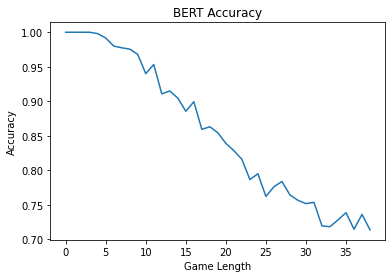

In [10]:
import matplotlib.pyplot as plt

plt.plot(benchmark)
plt.xlabel("Game Length")
plt.ylabel("Accuracy")
plt.title("BERT Accuracy")